In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 128, 128, 3)


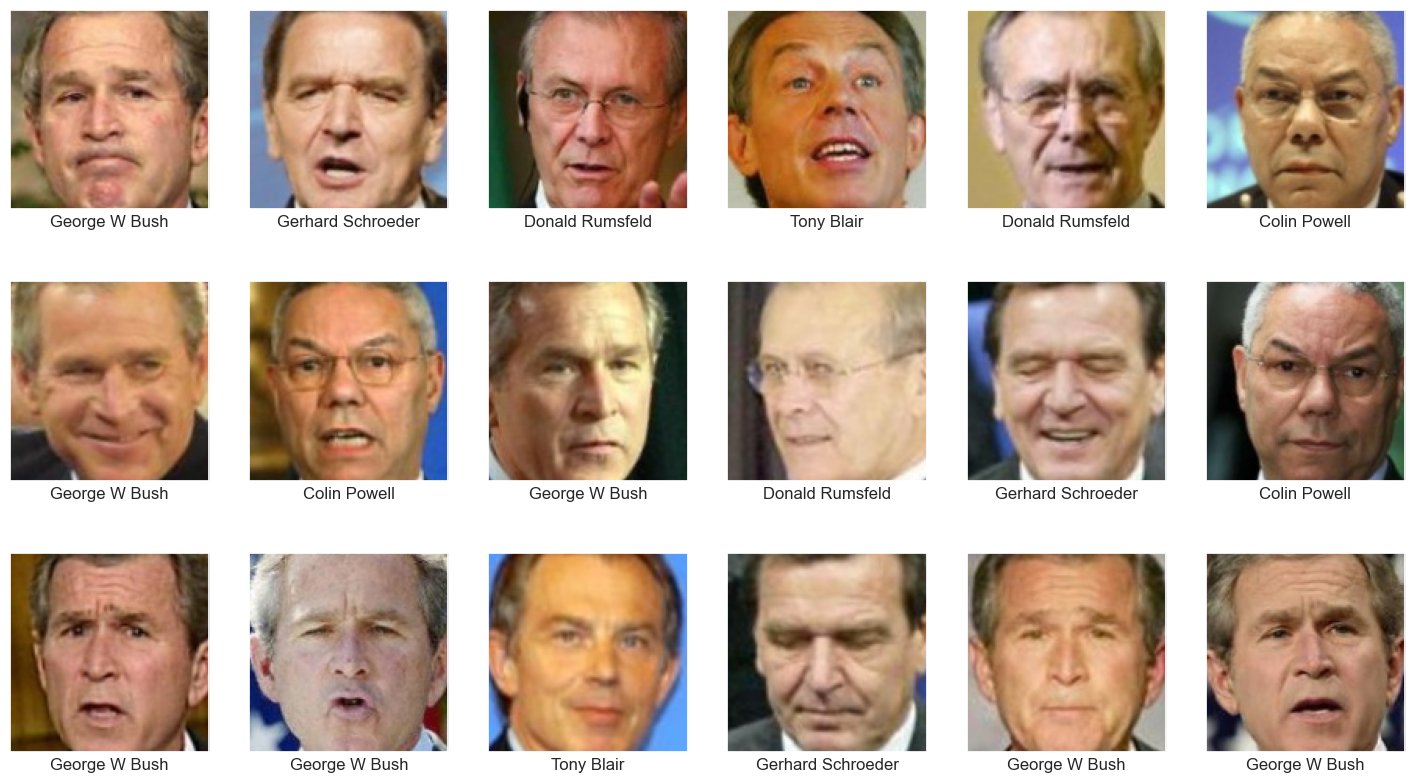

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i] / 255) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

<AxesSubplot:>

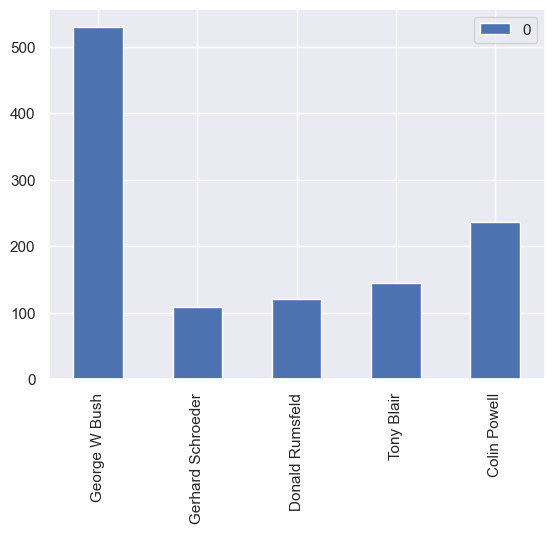

In [5]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

In [8]:
mask = np.zeros(faces.target.shape, dtype=bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

(500, 128, 128, 3)

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = x_faces / 255 # Normalize pixel values
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)

In [10]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(face_images.shape[1:])))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

In [11]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=25)

Epoch 1/20
16/16 [==============================] - 3s 135ms/step - loss: 1.6255 - accuracy: 0.2175 - val_loss: 1.5814 - val_accuracy: 0.2000
Epoch 2/20
16/16 [==============================] - 2s 124ms/step - loss: 1.5702 - accuracy: 0.2850 - val_loss: 1.5181 - val_accuracy: 0.3000
Epoch 3/20
16/16 [==============================] - 2s 128ms/step - loss: 1.3378 - accuracy: 0.5250 - val_loss: 1.2746 - val_accuracy: 0.5200
Epoch 4/20
16/16 [==============================] - 2s 126ms/step - loss: 0.8860 - accuracy: 0.7025 - val_loss: 0.8911 - val_accuracy: 0.6400
Epoch 5/20
16/16 [==============================] - 2s 125ms/step - loss: 0.6358 - accuracy: 0.7300 - val_loss: 0.8700 - val_accuracy: 0.6800
Epoch 6/20
16/16 [==============================] - 2s 126ms/step - loss: 0.5045 - accuracy: 0.8225 - val_loss: 1.0639 - val_accuracy: 0.6400
Epoch 7/20
16/16 [==============================] - 2s 135ms/step - loss: 0.3544 - accuracy: 0.8750 - val_loss: 0.7125 - val_accuracy: 0.7800
Epoch 

[]

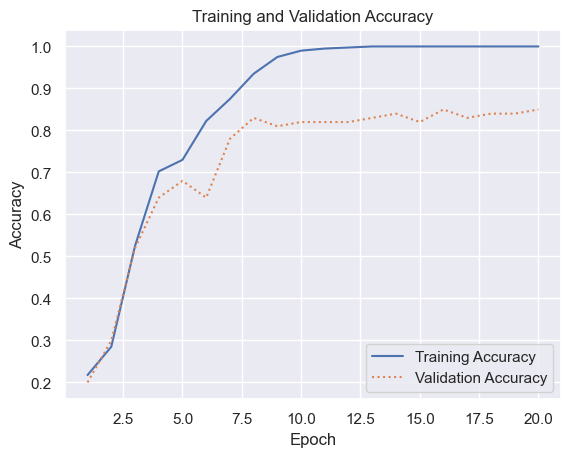

In [12]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

4/4 [==============================] - 0s 30ms/step


Text(110.44999999999996, 0.5, 'Actual label')

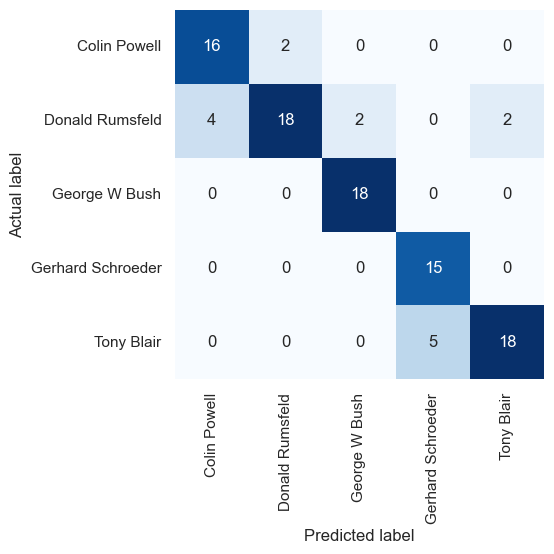

In [13]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

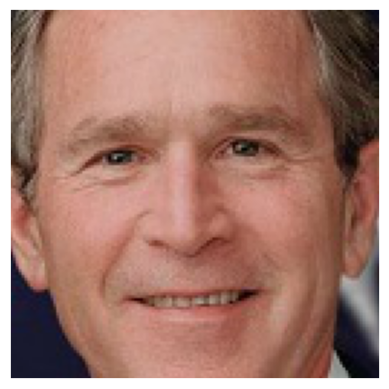

In [35]:
from keras.preprocessing import image

x = image.load_img('george.jpg', target_size=(face_images.shape[1:]))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [36]:
x = image.img_to_array(x) / 255
x = np.expand_dims(x, axis=0)
y = model.predict(x)[0]
print("y",max(y))

for i in range(len(y)):
    print(faces.target_names[i] + ': ' + str(y[i]))

1/1 [==============================] - 0s 16ms/step
y 0.999097
Colin Powell: 1.61438e-06
Donald Rumsfeld: 3.061144e-07
George W Bush: 0.999097
Gerhard Schroeder: 2.92821e-07
Tony Blair: 0.00090076384
